# 简单线性回归纯手写的实现
来自于李沐的线上网课， 不调用torch的一些库，只使用python的numpy和matplotlib，使用torch或者深度学习的思路来实现整个流程。

In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
%matplotlib inline

## 1. 创建伪造的数据或者数据集
使用真实的`w=[4,-1.2].T, b=4.2`来创建数据集，并且加入一些噪音，否则线性回归问题是以一个可以在数学上推导出准确解的问题，这里的噪音是为了模拟真实的数据。
`y = Wx + b + noise`

In [26]:
# 人造数据集
def synthetic_data(weight, bias, num_samples):
    x = torch.normal(0, 1, (num_samples, len(weight)))  # normal函数 均值为0，方差为1的正态分布
    # 矩阵乘以向量
    y = torch.matmul(x, weight) + bias
    y += torch.normal(0, 0.01, y.shape) # 添加噪声
    return x, y
weights = torch.tensor([4.0, -1.2], dtype=torch.float32).T
bias = torch.tensor(4.2, dtype=torch.float32)
features, labels = synthetic_data(weights, bias, 1000)
print(features.shape, labels.shape)
print(features[0], labels[0])

torch.Size([1000, 2]) torch.Size([1000])
tensor([-0.4679, -0.3185]) tensor(2.7117)


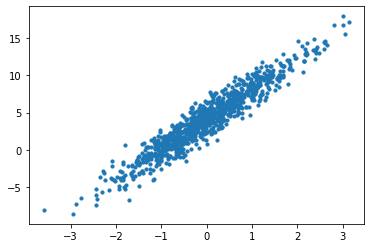

In [27]:
plt.scatter(features[:, 0], labels, s=10)
plt.show()

## 2.  创建数据加载器迭代加载数据集
小批量的读取数据集，可以使得训练满足自己的设备的要求，在某种程度上也能够提高训练速度和准确率。

torch.Size([8, 2]) torch.Size([8])
tensor([[ 1.2822,  2.2235],
        [-1.0220, -0.7334],
        [ 0.7188, -0.0924],
        [-0.4403, -0.0403],
        [ 0.6984, -1.5965],
        [ 2.1427,  0.6858],
        [-2.0843, -2.1378],
        [-0.0451, -0.8326]]) tensor([ 6.6601,  0.9767,  7.1921,  2.4768,  8.8955, 11.9559, -1.5568,  5.0069])


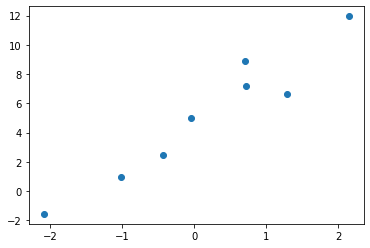

In [28]:
def data_iter(batch_size, features, labels):
    """
    打乱数据集，并每次读取一个批量的数据
    params:
        @batch_size: 批量的大小
        @features: 特征矩阵或者向量集合
        @labels: 标签集合
    return:
        yield 返回每个批次的数据集
    """
    num_samples = len(features)  # 获取总数
    indices = list(range(num_samples))  # 获取所有元素的下标
    random.shuffle(indices)  # 打乱这些下标，保证数据的随机读取
    # for i in range(1, int(num_samples / batch_size)):  自己实现的写法，不太完善
    #     index_end = i * batch_size
    #     index_start = index_end - batch_size
    #     yield features[index_start:index_end,:],labels[index_start:index_end]
    
    # 按照打乱的下标切分并读取
    for i in range(1, int(num_samples / batch_size)):
        indice = indices[i * batch_size - batch_size:min(batch_size * i, num_samples)]  # 后面的min是防止溢出
        yield features[indice], labels[indice]

for X, y in data_iter(8, features, labels):
    print(X.shape, y.shape)
    print(X, y)
    break
plt.scatter(X.numpy()[:,0], y.numpy())
plt.show()


## 3. 对模型的参数进行初始化
初始化模型的参数`w`和`b`

In [29]:
w = torch.randn([2,1], requires_grad=True)
b = torch.zeros(1, requires_grad = True)
print(w, b)

tensor([[-0.5696],
        [-1.8414]], requires_grad=True) tensor([0.], requires_grad=True)


## 4. 创建线性回归模型
创建线性回归模型函数，也就是y = wx + b

In [30]:
def linear(weight, bais, feature):
    """
    params:
        weight: 权重
        bais: 偏移
        x: batch_size 的向量集合
    """
    y = torch.matmul(feature, weight) + bais
    return y




## 5. 定义损失函数
使用平方误差函数，也就是预测值与真实值之间的差值的平方的1/2

In [31]:
def squared_loss(predict, labels):
    """
    @predict: 预测值 shape=(8,1)
    @labels: 真实值 shape=(8,)
    """
    return (labels - predict.reshape(labels.shape)) **2 / 2

## 6. 定义优化函数
核心就是梯度的方向就是变化最大的方向，而上面的损失函数的值最小，表示整个模型的精度越高，所以这个最优化问题就是使得上述的损失函数值最小。
利用梯度下降法，找到梯度最大的地方，然后计算出按照此梯度下降之后的值，从而计算出其参数，用来更新我门原来的参数。

In [32]:
def sgd(params, lr, batch_size):
    """
    @params: 模型的参数， params.grad 就是参数的梯度
    @lr: 在梯度的方向下降的大小
    @batch_size: 批量的大小
    """
    with torch.no_grad():
        for param in params:
            # 在梯度的方向下降
            param -= param.grad * lr / batch_size
            param.grad.zero_()

## 7. 模型的训练
有了损失函数，模型，优化器，就可以开始对模型进行训练了。

In [33]:
# 定义迭代的次数
num_epochs = 3
loss_fn = squared_loss
lr = 0.03
batch_size = 10
for i in range(num_epochs):
    for X, Y in data_iter(batch_size, features, labels):
        #  首先是前向传播计算一次预测结果
        predicts = linear(w, b, X)
        # print(predicts.shape)
        # print(Y.shape)
        # 计算损失
        loss = loss_fn(predicts, Y)
        # print(loss)
        # 损失方向传播计算梯度,每一个的单独的损失求和，也就是一个小批量的所有的损失，所有的损失再求梯度，最后得到的也就是整个损失的梯度
        loss.sum().backward()  # 利用张量的反向传播的性质可以直接求梯度,也就是求了w和b的梯度，结果会存在w和b张量里面
        # 利用求出来的梯度进行优化
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_loss = loss_fn(linear(w, b, features), labels).sum()
        print("Epoch {}, loss {:.2f}".format(i, train_loss))
 
print(w, b)


Epoch 0, loss 49.81
Epoch 1, loss 0.19
Epoch 2, loss 0.05
tensor([[ 3.9987],
        [-1.1996]], requires_grad=True) tensor([4.2003], requires_grad=True)


In [36]:
print("weight误差",weights-w.reshape(weights.shape))
print("bias误差", bias-b)

weight误差 tensor([ 0.0013, -0.0004], grad_fn=<SubBackward0>)
bias误差 tensor([-0.0003], grad_fn=<SubBackward0>)


## 8.可视化回归的结果

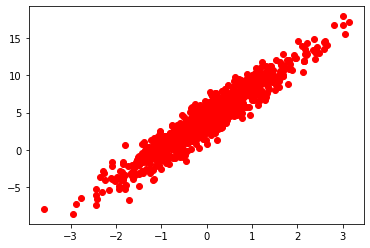

In [41]:
# no sence haha
with torch.no_grad():
    result_y = torch.matmul(features, w) + b
    plt.scatter(features[:,0].numpy(), result_y.numpy(), c="red")
    plt.show()